### Previous Work
The last group grouped calls based on their longitude and latitude.
Using the provided longitude and latitude values, the distance was calculated using the following formulas:

In [ ]:
distance = 0.0145 # about 1 mile
filtered_df['lat_bin'] = (filtered_df['Latitude'] // distance) * distance
filtered_df['lon_bin'] = (filtered_df['Longitude'] // distance) * distance

filtered_df['lat_bin'] = filtered_df['lat_bin'].round(2)
filtered_df['lon_bin'] = filtered_df['lon_bin'].round(2)

Once the distances were calculated, the data was grouped into bins based on 1 mile long sections

In [ ]:
grouped_data = filtered_df.groupby(['lat_bin', 'lon_bin'])
group_dict = {f'Group_{lat_bin}_{lon_bin}': group for (lat_bin, lon_bin), group in grouped_data}

These groups are the basis of how call volumes are organized spatially and forecasted.

However, the resulting forecast outputs and geoJSON file maps the call volume into square grids that do not effectively visualize call frequency. Additionally, calls seem to be visualized into smaller grid sections that do not touch, suggesting that calls are not coming in those areas.

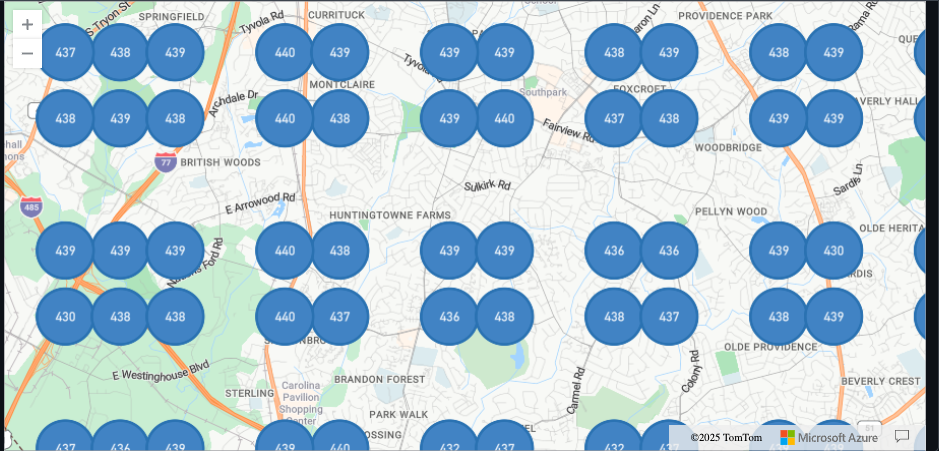
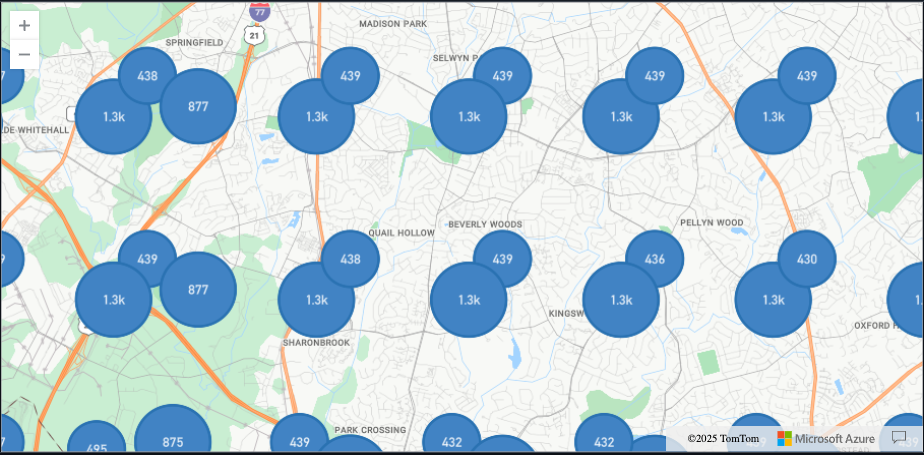

### Proposed Method

The proposed method is to spatially partition data using the H3 library.

H3 was developed by Uber to optimize ride pricing and dispatch, for visualizeing and exploring spatial data by using hexagons rather than traditional grid-based paritioning. 

https://www.uber.com/blog/h3/

H3 offers several benefits for grid-base geospatial applications:
- Hexagons provide more uniform coverage and has six neighbors, ensuring smoother and more consistent proximity calculations.
- Support multiple resolutions, allowing upscaling and downscaling of spatial data
- Helps normalize geographic data distributions by avoiding distortions caused by traditional latitude/longitude bins

Using H3 grid paritioning would allow us to bucket the data efficiently, create heatmaps easily that can be upscaled or downscaled, and create a more uniform coverage over the target area.

### Example

Using the Levrum provided data, call locations were paritioned using the **H3 library** into hexagonal buckets and mapped using **Folium**.

In [1]:
import h3
import pandas as pd
import folium
import branca.colormap as cm

In [2]:
# Set Charlotte, NC coordinates
lat, lng = 35.227085, -80.843124
resolution = 10

In [3]:
# Read CSV
df = pd.read_csv('CLT_Data.csv')

# Get EMS data
ems_df = df[df['CauseCategory'] == 'EMS'].reset_index()

# Convert 'Dispatched' column to datetime format
ems_df['Dispatched'] = pd.to_datetime(ems_df['Dispatched'])

# Get Date from 'Dispatched'
ems_df['Date'] = ems_df['Dispatched'].dt.date

# Group by Date, Longitude, Latitude
group_df = ems_df[['Date', 'Longitude', 'Latitude']].drop_duplicates().reset_index(drop=True)

group_df

Date  Longitude  Latitude
0       2018-07-01  -80.84423  35.23847
1       2018-07-01  -80.75413  35.24875
2       2018-07-01  -80.84516  35.20232
3       2018-07-01  -80.91026  35.30428
4       2018-07-01  -80.77311  35.12916
...            ...        ...       ...
487212  2024-06-30  -80.92548  35.14874
487213  2024-06-30  -80.91293  35.23620
487214  2024-06-30  -80.75915  35.20439
487215  2024-06-30  -80.75335  35.29763
487216  2024-06-30  -80.77076  35.38113

[487217 rows x 3 columns]

In [4]:
def compute_h3_and_boundaries(row, resolution=8):
    """
    Parse each row and create H3 index string and geometry boundaries
    """
    lat = row['Latitude']
    lng = row['Longitude']
    h3_index = h3.latlng_to_cell(lat, lng, resolution)
    boundaries = h3.cell_to_boundary(h3_index)
    return pd.Series([h3_index, boundaries])

In [5]:
# Apply formula to dataframe
group_df[['H3_Index', 'Boundaries']] = group_df.apply(compute_h3_and_boundaries, axis=1)
group_df[['H3_Index', 'Boundaries']]

H3_Index                                         Boundaries
0       8844d84dbdfffff  ((35.24466555862531, -80.84496112313776), (35....
1       8844dab0c3fffff  ((35.24996218507981, -80.75571150664247), (35....
2       8844d84d17fffff  ((35.205243202234094, -80.84556080259782), (35...
3       8844dab6cdfffff  ((35.3079174247295, -80.91012194043648), (35.3...
4       8844d84999fffff  ((35.13336098546182, -80.76758167951995), (35....
...                 ...                                                ...
487212  8844d84e2dfffff  ((35.151812218738186, -80.92217130467942), (35...
487213  8844d84ca9fffff  ((35.24162981834797, -80.90773982983686), (35....
487214  8844dab05bfffff  ((35.21053514115991, -80.75638361529961), (35....
487215  8844dab563fffff  ((35.30203556770204, -80.75151655005044), (35....
487216  8844dab5b7fffff  ((35.38425145900736, -80.76997650593837), (35....

[487217 rows x 2 columns]

In [6]:
# Aggregate count of each H3 index
call_counts = group_df.groupby('H3_Index').size().reset_index(name='Count')
call_counts

H3_Index  Count
0     882a8b69a9fffff      1
1     882a8b69adfffff      1
2     8844d84011fffff     25
3     8844d84013fffff    105
4     8844d84015fffff     35
...               ...    ...
1590  8844dbd347fffff      1
1591  8844dbd349fffff      1
1592  8844dbd34dfffff      1
1593  8844dbd367fffff      1
1594  8844dbd36dfffff      1

[1595 rows x 2 columns]

In [7]:
# Merge boundaries with call_counts
call_counts = call_counts.merge(
    group_df[['H3_Index', 'Boundaries']].drop_duplicates(), on='H3_Index', how='left'
)
call_counts

H3_Index  Count  \
0     882a8b69a9fffff      1   
1     882a8b69adfffff      1   
2     8844d84011fffff     25   
3     8844d84013fffff    105   
4     8844d84015fffff     35   
...               ...    ...   
1590  8844dbd347fffff      1   
1591  8844dbd349fffff      1   
1592  8844dbd34dfffff      1   
1593  8844dbd367fffff      1   
1594  8844dbd36dfffff      1   

                                             Boundaries  
0     ((35.82766633426213, -80.23762705105113), (35....  
1     ((35.829327744458574, -80.24761336799331), (35...  
2     ((35.08421797030546, -80.99219731232341), (35....  
3     ((35.09130083638936, -80.9954021105329), (35.0...  
4     ((35.08263431812397, -80.98234500699878), (35....  
...                                                 ...  
1590  ((35.49760753715459, -80.85769569052191), (35....  
1591  ((35.48654577429479, -80.87113499355513), (35....  
1592  ((35.48494364720243, -80.86120361073036), (35....  
1593  ((35.49992957910377, -80.83110562292904), (35....  
1594  ((35.48726581155264, -80.83462073193566), (35....  

[1595 rows x 3 columns]

In [10]:
m = folium.Map(location=[lat, lng], zoom_start=11, tiles='cartodbpositron')

# Create a color map using shades of red
colormap = cm.LinearColormap(colors=['#ffcccc', '#ff0000'], vmin=call_counts['Count'].min(), vmax=80)

# Add the H3 cells to the map with color based on count
for _, row in call_counts.iterrows():
    boundaries = row['Boundaries']
    count = row['Count']
    color = colormap(count)
    folium.Polygon(
        locations=boundaries,
        color=color,
        weight=1,
        fill=True,
        fill_opacity=0.7,
        popup=f'Count: {count}'
    ).add_to(m)

# Add the colormap to the map
colormap.add_to(m)


# Display the map
m